# Imports: 

In [142]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [143]:
cols = sns.color_palette("tab10")

# Functions: 

In [150]:
def classifier(X, df_lfc, list_categories, model, reg_param_list, shuffle, version, plotting = False):

    n_splits = 5
    n_classes = 2
    list_log_loss = []
    list_roc_auc = []

    pp_dict = {}
    
    for category in list_categories: # For each gene functional category
        print(category)
        # create y-vector of 0's (doesn't belong to category) and 1's (belongs to category)
        y = np.zeros(df_lfc.shape[0])
        ind_ones = [i for i in range(df_lfc.shape[0]) if df_lfc.iloc[i].Functional_Category == category]
        y[ind_ones] = 1
        
        if shuffle: # shuffle y vector.
            random.shuffle(y)

        # prediction probabilities matrix (empty): 
        pp_mat = np.zeros((len(y), n_classes))
        
        counter = 0 # used for figure filename, to know what reg. parameter was used. 
        for reg_param_temp in reg_param_list:   # For each regularization parameter: 
#             print("C = ", reg_param_temp)
            log_loss_var = [] # stores log-loss in each fold
            roc_auc = []
            confusion = np.zeros((n_classes, n_classes)) # initialize confusion matrix. 
    
            if model == 'logreg':
                clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)
    #             clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=reg_param_temp)
            elif model == 'xgbc':
                clf = XGBClassifier(gamma = reg_param_temp, reg_alpha=1, reg_lambda=1, eval_metric='logloss', use_label_encoder=False)
            elif model == 'forest':
                clf=RandomForestClassifier(n_estimators=100)

            skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                X_train, y_train = SMOTE().fit_resample(X_train, y_train) # understand this step. 
                # fit model
                clf.fit(X_train, y_train)
                # predict on test set
                y_hat = clf.predict(X_test)
                # compute: confusion matrix, accuracy, log-loss
                confusion += confusion_matrix(y_test, y_hat)
                y_pred = clf.predict_proba(X_test)
                
                # update prediction probabilities matrix
                pp_mat[test_index,:]=clf.predict_proba(X_test)
                log_loss_var.append(log_loss(y_test, y_pred))
                roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))

            # normalize confusion matrix
            confusion = normalize(confusion, axis=1, norm='l1')
            list_log_loss.append( np.mean(log_loss_var) )
            list_roc_auc.append( np.median(roc_auc) )
            pp_dict[category] = pp_mat
            
    df_accuracy = pd.DataFrame()
    ll_categories_temp = [len(reg_param_list)*[l] for l in list_categories]
    ll_categories = [item for sublist in ll_categories_temp for item in sublist]
    df_accuracy['category'] = ll_categories
    df_accuracy['C_reg'] = len(list_categories)*list(reg_param_list)
    df_accuracy['log_loss'] = list_log_loss
    df_accuracy['roc_auc'] = list_roc_auc

    return df_accuracy, confusion, pp_dict

## Load datasets: 

In [151]:
# version = 'old'
version = 'clare_basis'
# version = 'clare_all'

In [152]:
if version == 'old':
    fn = 'lfc_mb_filt_OLD.csv' ## data set without Claire's screens
elif version == 'clare_all':
    fn = 'lfc_mb_filt.csv' ## data set with all of Claire's pairwise combinations
elif version == 'clare_basis':
    fn = 'lfc_mb_filt_BASIS.csv' ## data set only Claire's mutant vs. wildtype screens

path = '../data/standardized_data/cleaned_ML/'
df_lfc = pd.read_csv(os.path.join(path, fn))
df_lfc.shape

(2937, 127)

In [153]:
cols_data = df_lfc.columns[1:-1]
X = df_lfc[cols_data].to_numpy()
print(X.shape)

list_categories = df_lfc.Functional_Category.unique().tolist()
list_categories

(2937, 125)


['information pathways',
 'cell wall and cell processes',
 'intermediary metabolism and respiration',
 'regulatory proteins',
 'virulence, detoxification, adaptation',
 'insertion seqs and phages',
 'lipid metabolism',
 'PE/PPE']

### Get logistic regression and XGB probabilities:
With a single parameter (L1, gamma)

In [154]:
shuffle = False 
# logistic regression
model = 'logreg'
reg_param_list = np.array([1e-1])
print(model)
df_accuracy_lr, confusion_lr, pp_dict_lr = classifier(X, df_lfc, list_categories, model, reg_param_list, shuffle, version, plot_param)
# xgbc
model = 'xgbc'
print(model)
reg_param_list = np.array([100])
df_accuracy_xgbc, confusion_xgbc, pp_dict_xgbc = classifier(X, df_lfc, list_categories, model, reg_param_list, shuffle, version, plot_param)

logreg
information pathways
[[0.66679035 0.33320965]
 [0.40082645 0.59917355]]
cell wall and cell processes
[[0.57294552 0.42705448]
 [0.46822309 0.53177691]]
intermediary metabolism and respiration
[[0.55189621 0.44810379]
 [0.41050375 0.58949625]]
regulatory proteins
[[0.67481752 0.32518248]
 [0.56345178 0.43654822]]
virulence, detoxification, adaptation
[[0.68273831 0.31726169]
 [0.54090909 0.45909091]]
insertion seqs and phages
[[0.86332737 0.13667263]
 [0.33098592 0.66901408]]
lipid metabolism
[[0.61754781 0.38245219]
 [0.48518519 0.51481481]]
PE/PPE
[[0.7790991  0.2209009 ]
 [0.38271605 0.61728395]]
xgbc
information pathways
[[0.77699443 0.22300557]
 [0.49173554 0.50826446]]
cell wall and cell processes
[[1. 0.]
 [1. 0.]]
intermediary metabolism and respiration
[[1. 0.]
 [1. 0.]]
regulatory proteins
[[0.63576642 0.36423358]
 [0.59390863 0.40609137]]
virulence, detoxification, adaptation
[[0.61869709 0.38130291]
 [0.52272727 0.47727273]]
insertion seqs and phages
[[0.8686941  0.13

### Compare xgb vs. log. regression: 

XGBC gamma = 10

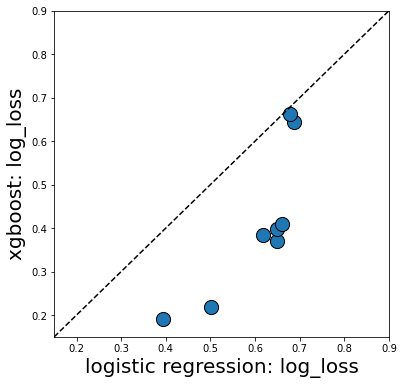

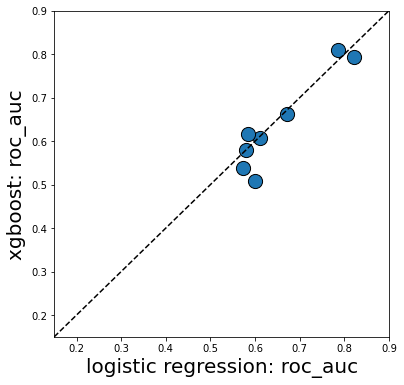

In [121]:
for metric in ['log_loss', 'roc_auc']:
    plt.figure(figsize=(6,6))
    plt.scatter(df_accuracy_lr[metric], df_accuracy_xgbc[metric], s=200, edgecolors='k')
    xymin = 0.15
    xymax = 0.9
    xyline = np.linspace(xymin, xymax, 100)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.plot(xyline, xyline, 'k--')

    plt.xlabel('logistic regression: '+metric, fontsize = 20)
    plt.ylabel('xgboost: '+metric, fontsize = 20)

XGBC gamma = 100

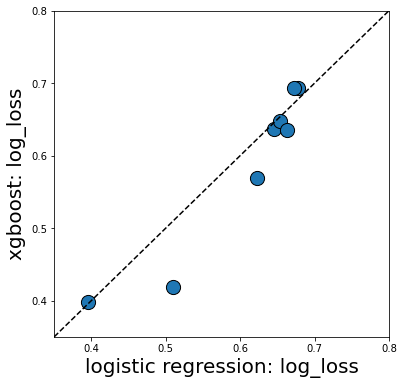

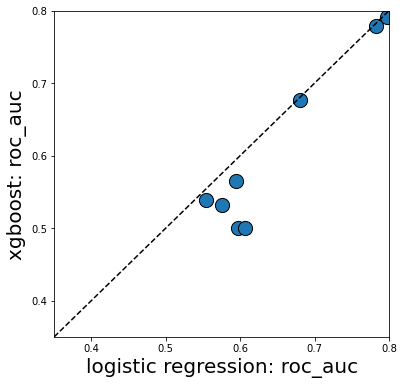

In [155]:
for metric in ['log_loss', 'roc_auc']:
    plt.figure(figsize=(6,6))
    plt.scatter(df_accuracy_lr[metric], df_accuracy_xgbc[metric], s=200, edgecolors='k')
    xymin = 0.35
    xymax = 0.8
    xyline = np.linspace(xymin, xymax, 100)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.plot(xyline, xyline, 'k--')

    plt.xlabel('logistic regression: '+metric, fontsize = 20)
    plt.ylabel('xgboost: '+metric, fontsize = 20)

## Ensemble learning: 

In [156]:
n_classes = 2
n_splits = 5

In [157]:
list_log_loss = []
list_roc_auc = []

for category in list_categories:
    print(category)
    # category = 'information pathways'
    pp_mat_lr = pp_dict_lr[category]
    pp_mat_xgbc = pp_dict_xgbc[category]
    pp_mat_lr_xgbc = np.concatenate((pp_mat_lr,pp_mat_xgbc), axis=1)
    # create X matrix
    X = pp_mat_lr_xgbc.copy()

    # create y-vector of 0's (doesn't belong to category) and 1's (belongs to category)
    y = np.zeros(df_lfc.shape[0])
    ind_ones = [i for i in range(df_lfc.shape[0]) if df_lfc.iloc[i].Functional_Category == category]
    y[ind_ones] = 1

    reg_param_list = np.array([1e-2, 1e-1, 1e0, 1e1]) # range of logistic regression L1 regularization parameter: 
    for reg_param_temp in reg_param_list:
        accuracy = [] # stores accuracy in each fold
        log_loss_var = [] # stores log-loss in each fold
        roc_auc = []

        clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)   

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            X_train, y_train = SMOTE().fit_resample(X_train, y_train) # understand this step. 
            # fit model
            clf.fit(X_train, y_train)
            # predict on test set
            y_hat = clf.predict(X_test)
            # compute: confusion matrix, accuracy, log-loss
            y_pred = clf.predict_proba(X_test)
            log_loss_var.append(log_loss(y_test, y_pred))
            roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))
            
        list_log_loss.append( np.median(log_loss_var) )
        list_roc_auc.append( np.median(roc_auc) )
        
df_accuracy_ens = pd.DataFrame()
ll_categories_temp = [len(reg_param_list)*[l] for l in list_categories]
ll_categories = [item for sublist in ll_categories_temp for item in sublist]
df_accuracy_ens['category'] = ll_categories
df_accuracy_ens['C_reg'] = len(list_categories)*list(reg_param_list)
df_accuracy_ens['log_loss'] = list_log_loss
df_accuracy_ens['log_loss'] = list_log_loss
df_accuracy_ens['roc_auc'] = list_roc_auc

information pathways
cell wall and cell processes
intermediary metabolism and respiration
regulatory proteins
virulence, detoxification, adaptation
insertion seqs and phages


/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lipid metabolism
PE/PPE


## Bar plot: ensembled vs. log-reg vs. xgbc vs. shuffled (?)

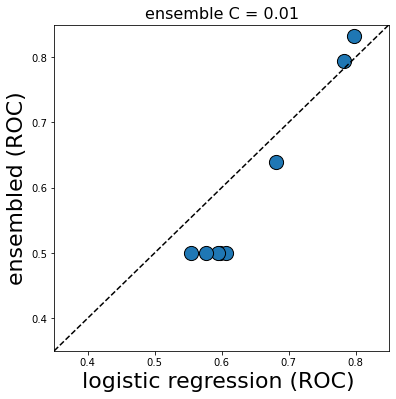

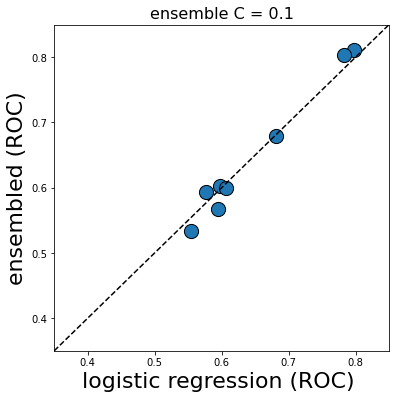

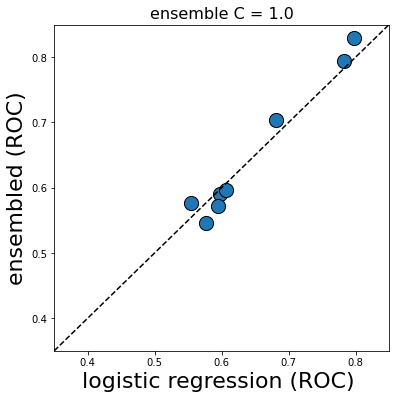

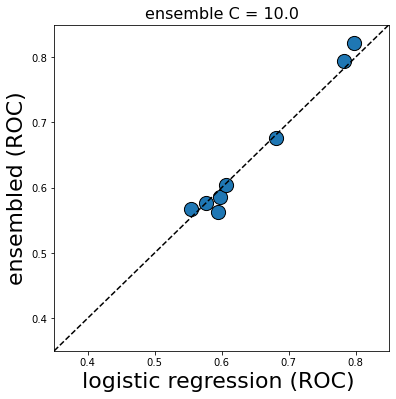

In [158]:
metric = 'roc_auc'
for C in df_accuracy_ens.C_reg.unique():
    plt.figure(figsize=(6,6))

    df_accuracy_ens_C = df_accuracy_ens[df_accuracy_ens.C_reg==C].copy()
    plt.scatter(df_accuracy_lr[metric], df_accuracy_ens_C[metric], s=200, edgecolors='k')
    xymin = 0.35
    xymax = 0.85
    xyline = np.linspace(xymin, xymax, 100)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.plot(xyline, xyline, 'k--')

    plt.xlabel('logistic regression (ROC) ', fontsize = 22)
    plt.ylabel('ensembled (ROC)', fontsize = 22)
    
    plt.title('ensemble C = '+ str(C), fontsize = 16)

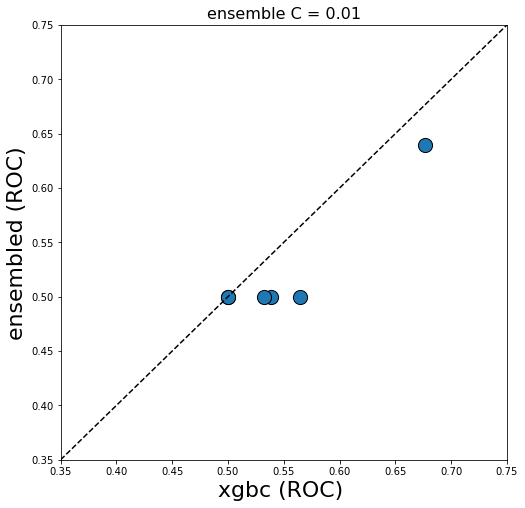

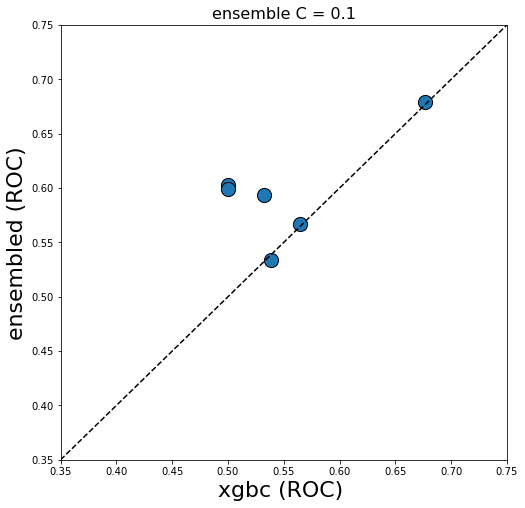

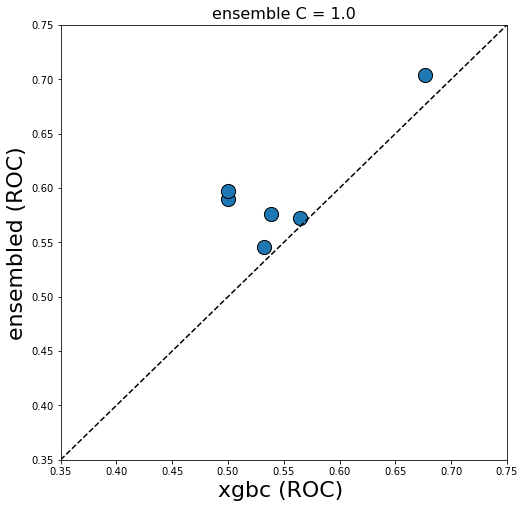

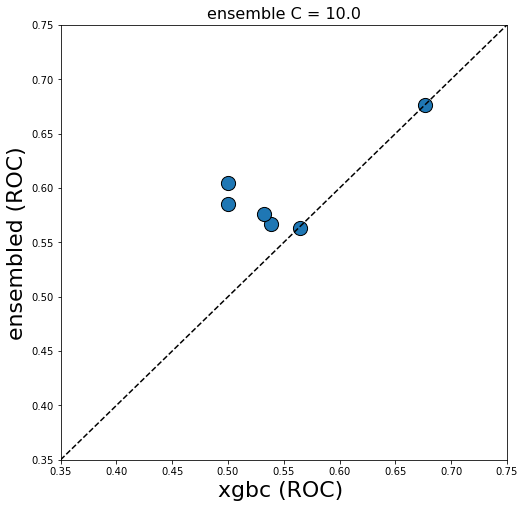

In [159]:
for C in df_accuracy_ens.C_reg.unique():

    plt.figure(figsize=(8,8))

    df_accuracy_ens_C = df_accuracy_ens[df_accuracy_ens.C_reg==C].copy()
    plt.scatter(df_accuracy_xgbc[metric], df_accuracy_ens_C[metric], s=200, edgecolors='k')
    xymin = 0.35
    xymax = 0.75
    xyline = np.linspace(xymin, xymax, 100)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.plot(xyline, xyline, 'k--')

    plt.xlabel('xgbc (ROC) ', fontsize = 22)
    plt.ylabel('ensembled (ROC)', fontsize = 22)
    plt.title('ensemble C = '+ str(C), fontsize = 16)